### Homework 04  Yifan (Crystal) CAI

In [48]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

1. Using hotel_cancellation.csv, write code to estimate the treatment effects if a ‘different room is assigned’ as the treatment indicator and interpret its effect on the room being ‘canceled’. Use all the other columns as the covariates. Write your observations for the results.

In [2]:
#Import Dataset
hotel = pd.read_csv("/Users/crystal/Desktop/assign04_0212/hotel_cancellation.csv")
hotel.head()
hotel['different_room_assigned'] = np.where(hotel['different_room_assigned'] == True, 1, 0).astype('int')
hotel['is_canceled'] = np.where(hotel['is_canceled'] == True, 1, 0).astype('int')

,Unnamed: 0,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,days_in_waiting_list,different_room_assigned,is_canceled
0,3,13,2015,27,1,0,False,False
1,4,14,2015,27,1,0,False,False
2,5,14,2015,27,1,0,False,False
3,7,9,2015,27,1,0,False,False
4,8,85,2015,27,1,0,False,True


In [3]:
# Logistic Regression of is_canceled on other variables 
log = smf.logit("is_canceled ~ lead_time + arrival_date_year + arrival_date_week_number + arrival_date_day_of_month + days_in_waiting_list + different_room_assigned", data = hotel).fit()
log.summary()

Optimization terminated successfully.
         Current function value: 0.597308
         Iterations 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_canceled   No. Observations:               102894
Model:                          Logit   Df Residuals:                   102887
Method:                           MLE   Df Model:                            6
Date:                Sat, 11 Feb 2023   Pseudo R-squ.:                  0.1070
Time:                        20:37:19   Log-Likelihood:                -61459.
converged:                       True   LL-Null:                       -68825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   356.5464     23.369     15.257      0.000     310.745     402.348
lead_time                     0.0053   6.92e-05     77.154      0.000       0.005       0.005
arrival_date_year            -0.1772      0.012    -15.290      0.000      -0.200      -0.154
arrival_date_week_number     -0.0093      0.001    -14.805      0.000      -0.011      -0.008
arrival_date_day_of_month    -0.0006      0.001     -0.771      0.441      -0.002       0.001
days_in_waiting_list          0.0008      0.000      1.950      0.051   -3.73e-06       0.002
different_room_assigned      -2.5500      0.044    -58.102      0.000      -2.636      -2.464
=============================================================================================
"""

In [4]:
# Calculating Odds Ratios
np.set_printoptions(suppress = True)
odds_ratios = pd.DataFrame(
    {
        "Odds Ratio": log.params,
        "Lower CI": log.conf_int()[0],
        "Upper CI": log.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                              Odds Ratio       Lower CI       Upper CI
Intercept                  7.016715e+154  9.010330e+134  5.464205e+174
lead_time                   1.005351e+00   1.005215e+00   1.005488e+00
arrival_date_year           8.376460e-01   8.188377e-01   8.568863e-01
arrival_date_week_number    9.907246e-01   9.895031e-01   9.919476e-01
arrival_date_day_of_month   9.993996e-01   9.978747e-01   1.000927e+00
days_in_waiting_list        1.000766e+00   9.999963e-01   1.001536e+00
different_room_assigned     7.808554e-02   7.164961e-02   8.509959e-02


In [5]:
# Extract the coefficient for the 'different_room_assigned' variable
TE_coeff = log.params['different_room_assigned']
TE_odds_ratio = round(np.exp(TE_coeff),3)
TE_odds_ratio

0.078

**Interpretation:** <br>
The odds of the room being canceled if a different room is assigned are 0.078 times the odds of the room being canceled if the same room is assigned. In other words, having a different room assigned makes it less likely that the room will be canceled. 

2. For hotel_cancellation.csv, now use double lasso regression to measure the effect of ‘different room is assigned’ on the room being ‘canceled’.

In [39]:
# Predict y_hat using the fitted model
y_hat = log.predict(hotel).values.reshape(-1, 1)
# Creat new dataframe that includes Xs and y_hat (predicted y)
x = hotel[['lead_time','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','days_in_waiting_list','different_room_assigned']]
y = hotel['is_canceled']
hotel_new = pd.DataFrame(np.hstack((x, y_hat)))
hotel_new.columns = ['lead_time', 'arrival_date_year','arrival_date_week_number',
                 'arrival_date_day_of_month','days_in_waiting_list','different_room_assigned','y_hat']
hotel_new['y'] = np.array(hotel['is_canceled'])

#Second logistic regression : y ~ Xs + y_hat
log2 = smf.logit("y ~ lead_time + arrival_date_year + arrival_date_week_number + arrival_date_day_of_month + days_in_waiting_list + different_room_assigned + y_hat", data = hotel_new).fit()
log2.summary()

         Current function value: 0.597285
         Iterations: 35


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               102894
Model:                          Logit   Df Residuals:                   102886
Method:                           MLE   Df Model:                            7
Date:                Sat, 11 Feb 2023   Pseudo R-squ.:                  0.1070
Time:                        22:30:10   Log-Likelihood:                -61457.
converged:                      False   LL-Null:                       -68825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   278.4354     43.021      6.472      0.000     194.117     362.754
lead_time                     0.0042      0.001      7.717      0.000       0.003       0.005
arrival_date_year            -0.1386      0.021     -6.515      0.000      -0.180      -0.097
arrival_date_week_number     -0.0073      0.001     -6.609      0.000      -0.010      -0.005
arrival_date_day_of_month    -0.0005      0.001     -0.587      0.557      -0.002       0.001
days_in_waiting_list          0.0006      0.000      1.563      0.118      -0.000       0.001
different_room_assigned      -2.1999      0.167    -13.210      0.000      -2.526      -1.873
y_hat                         0.9489      0.439      2.161      0.031       0.088       1.810
=============================================================================================
"""

In [55]:
# Extract the coefficient for the 'different_room_assigned' variable
TE_coeff_01 = log2.params['different_room_assigned']
TE_odds_ratio_01 = round(np.exp(TE_coeff_01),3)
TE_odds_ratio_01

0.111

**Comment:** <br>
The odds of the room being canceled if a different room is assigned are 0.111 times the odds of the room being canceled if the same room is assigned. In other words, having a different room assigned makes it less likely that the room will be canceled. 

3. Use bootstrap to estimate the standard error of the treatment effects measured in (2). <br>

In [16]:
# Define the number of bootstrap resamples
n_resamples = 1000

# Initialize a matrix to store the treatment effect estimates
treat_effects = np.zeros((n_resamples, model2.params.shape[0] - 1))

# Use bootstrapping to estimate the standard error of the treatment effects
i = 0
while i < n_resamples:
    resample_index = np.random.choice(hotel.index, size = hotel.index.size, replace = True)
    resample = hotel.iloc[resample_index]
    x_resample = x.iloc[resample_index]
    y_resample = y.iloc[resample_index]
    model1 = sm.Logit(y_resample, x_resample).fit()
    y_hat = np.array(model1.predict(x_resample)).reshape(len(y_hat), 1)
    x_new = np.hstack((x_resample, y_hat))
    model2 = sm.Logit(y_resample, x_new).fit()
    treat_effects[i, :] = model2.params[:-1]
    i += 1

# Calculate the standard error of the treatment effects
treat_effects_se = treat_effects.std(axis=0)

# # Print the standard errors of the treatment effect estimates
print('Standard errors of the treatment effects:')
print(treat_effects_se)
# print(treat_effects)

Optimization terminated successfully.
         Current function value: 0.599413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599397
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597828
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599583
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597046
  

Optimization terminated successfully.
         Current function value: 0.595751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595949
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598905
  

Optimization terminated successfully.
         Current function value: 0.598585
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599928
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599632
  

Optimization terminated successfully.
         Current function value: 0.596146
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598801
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598537
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598493
  

Optimization terminated successfully.
         Current function value: 0.598366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596383
  

Optimization terminated successfully.
         Current function value: 0.599240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599135
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597958
  

Optimization terminated successfully.
         Current function value: 0.596665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597446
  

Optimization terminated successfully.
         Current function value: 0.597566
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598937
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597095
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597496
  

Optimization terminated successfully.
         Current function value: 0.598643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599704
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597959
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598221
  

Optimization terminated successfully.
         Current function value: 0.597480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598579
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598550
  

Optimization terminated successfully.
         Current function value: 0.599183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.602461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.602349
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599650
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599605
  

Optimization terminated successfully.
         Current function value: 0.597702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597814
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599320
  

Optimization terminated successfully.
         Current function value: 0.599388
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597204
  

Optimization terminated successfully.
         Current function value: 0.597793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599519
  

Optimization terminated successfully.
         Current function value: 0.599000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597126
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597455
  

Optimization terminated successfully.
         Current function value: 0.598170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599959
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599910
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597264
  

Optimization terminated successfully.
         Current function value: 0.598955
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597720
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597647
  

Optimization terminated successfully.
         Current function value: 0.598207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597851
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599066
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598200
  

Optimization terminated successfully.
         Current function value: 0.597761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596880
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599540
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598499
  

Optimization terminated successfully.
         Current function value: 0.598071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597992
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598074
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597980
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596314
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598617
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598527
  

Optimization terminated successfully.
         Current function value: 0.598677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598707
  

Optimization terminated successfully.
         Current function value: 0.598392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598439
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599940
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599860
  

Optimization terminated successfully.
         Current function value: 0.599014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599015
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598037
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597177
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597102
  

Optimization terminated successfully.
         Current function value: 0.599113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598222
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598596
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598405
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598336
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599332
  

Optimization terminated successfully.
         Current function value: 0.598787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599430
  

4. Use the drinking.csv for this question. Keeping 21 as the threshold for age, explore the data with an RDD by writing very simple code (no package needed, just average to one side of the threshold minus average to the other side) to determine if alcohol increases the chances of death by accident, suicide and/or others (the three given columns) and comment on the question “Should the legal age for drinking be reduced from 21?” based on the results. Plot graphs to show the discontinuity (if any) and to show results for the change in chances of death with all the three features (i.e., accident vs age, suicide vs age and others vs age). For this problem, choose the bandwidth to be 1 year (i.e., 21 +- 1). What might be the effect of choosing a smaller bandwidth?  What if we chose the maximum bandwidth? <br>

In [40]:
drink = pd.read_csv('/Users/crystal/Desktop/assign04_0212/drinking.csv')
drink = drink.dropna(axis = 0, how = 'any')
drink.head()

,age,others,accident,suicide
0,19.068493,92.825401,35.829327,11.203714
1,19.150684,95.100739,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315069,88.427757,32.278957,11.275010
4,19.397261,88.704941,32.650967,10.984314


(48, 4)

In [207]:
#As the bandwidth is set to be 1, so we filter out the data we will focus on, merely, observations with age between 20 to 22.
df = drink[(drink["age"] >= 20) & (drink["age"] <= 22)]

In [209]:
# Others 
np.mean(df['others'][df['age'] >= 21]) - np.mean(df['others'][df['age'] < 21])

6.5416600833333405

In [210]:
# Accident 
np.mean(df['accident'][df['age'] >= 21]) - np.mean(df['accident'][df['age'] < 21])

1.3384858333333405

In [208]:
#Suicide
np.mean(df['suicide'][df['age'] >= 21]) - np.mean(df['suicide'][df['age'] < 21])

1.7190783333333357

<Figure size 576x576 with 0 Axes>

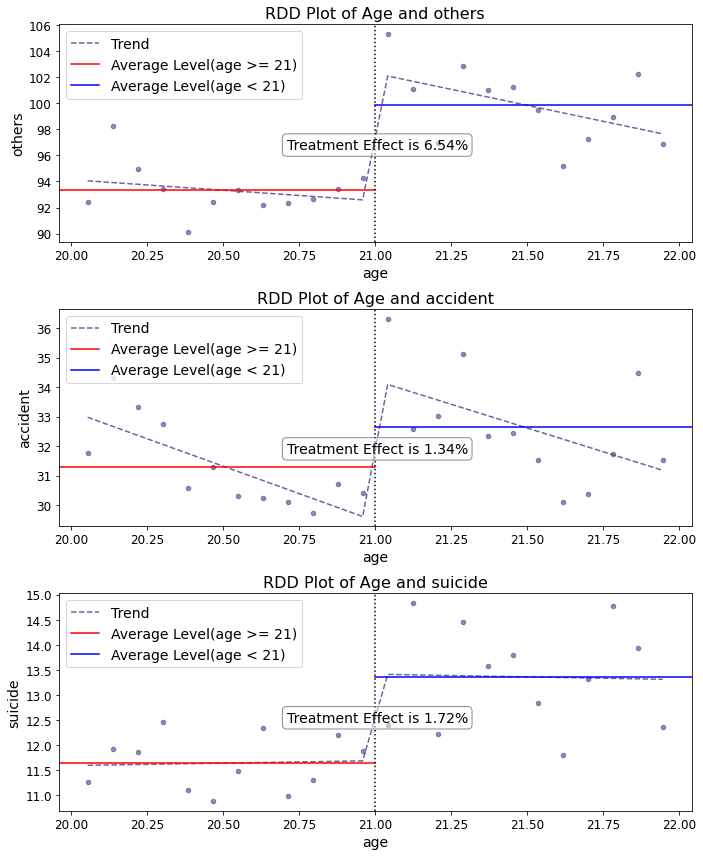

In [237]:
## Build RDD dataframe by adding "threshold" to the original dataset 
rdd_df = drink.assign(threshold=(df["age"] > 21).astype(int))
plt.figure(figsize=(8,8))

fig = plt.figure(figsize=(10, 12))
for p, cause in enumerate(["others", "accident", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    df.plot.scatter(x="age", y=cause, ax=ax, color = 'darkslateblue', alpha=0.6)
    
    m = smf.wls(f"{cause}~age*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    df.assign(predictions=m.fittedvalues).plot(x="age", y="predictions", ax=ax, color= "darkslateblue",  linestyle='--', alpha = 0.8,label='Trend')       
    
    below21_mean = np.mean(df[cause][df['age'] < 21])
    above21_mean = np.mean(df[cause][df['age'] >= 21])          
    plt.axhline(xmin=0, xmax=0.5, y= below21_mean, color='red', linestyle='-', label='Average Level(age >= 21)')
    plt.axhline(xmin=0.5, xmax=1, y= above21_mean, color='blue', linestyle='-', label='Average Level(age < 21)')
    
    gap = round((above21_mean - below21_mean),2)
    gap_pct = round((below21_mean - above21_mean)/min(below21_mean,above21_mean)* 100,2)
    y_pos = (abs(below21_mean + above21_mean) / 2 - min(df[cause])) / (max(df[cause]) - min(df[cause]))
    plt.annotate(f"Treatment Effect is {gap}%", (0.36, y_pos), xycoords='axes fraction', fontsize = 14,
                bbox= dict(boxstyle="round", fc = w', ec = '0.1', alpha=0.5))                  
    
    plt.axvline(x=21, color='black', linestyle=':')
    plt.legend(loc='best', fontsize=14)
    ax.set_xlabel("age", fontsize=14)
    ax.set_ylabel(cause, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.title(f"RDD Plot of Age and {cause}", fontsize = 16)

plt.tight_layout()
plt.show();

**Comment:**<br>
**1. Does alcohol increase the chances of death by accident, suicide and/or others (the three given columns) ?** <br>
We can tell that alcohol tend to increases the chance of death by accident, suicide and/or others based on the fact that people who are 21 age larger, in other words, who are legally allowed to drink, tend to have higher chance of death by accident, suicide and/or others. <br>
**2. Comment on the question “Should the legal age for drinking be reduced from 21?” based on the results**<br>
Even when we currently set legal age for drinking to be 21, alcohol tend to increases the chances of death, this suggests that even people are of 21 years old cannot performly well under the permission of alcohol. Therefore, we cannot be confident to set the legal age for drinking to be yonger than 21, this may post more risks to the society and young people, because younger people are expected to have lower ability of perform well than those older than them. <br>
**3. What might be the effect of choosing a smaller bandwidth? What if we chose the maximum bandwidth?**<br>
Choosing a smaller bandwidth might lead to a more precise estiamtion of treatment effect, as the observations near the cutoff point are expected to be more similar and to provide a more reliable estimate; Besides, when we have a smaller bandwidth, there are smaller number of observations for RDD, therefore, the observed treatment effect may be of lower external validity as the sample size is too small.<br>
If we choose the maximum bandwidth, firstly, the estimate of treatment effect may not be valid at this point of time, as validity of RDD is built on the assumption that observations that are close to the threshold is similar enough to each other, observations in wider bandwidth may be very different; secondly, the estimate of treatment effect can be affected by more confounders, in other words, we are less likely to estimate a pure treatment effect.

5. Use the iris.csv for this question. How does the performance of k-nearest neighbors change as k takes on the following values: 1, 3, 5, 7? Which of these is the optimal value of k? Which distance/similarity metric did you choose to use and why?

In [42]:
iris = pd.read_csv('/Users/crystal/Desktop/assign04_0212/iris.csv')
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [50]:
# Split the data into training and testing sets
x = iris[['sepal.length','sepal.width','petal.length','petal.width']]
y = iris['variety']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train= np.asarray(x_train)
y_train= np.asarray(y_train)
x_test= np.asarray(x_test)
y_test= np.asarray(y_test)

In [56]:
# KNN when K = 1,3,5,7 using distance metric of manhattan
for k in [1,3,5,7]:
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'manhattan')
    knn.fit(x_train_n, y_train)
    y_pred = knn.predict(x_test_n)
    accuracy = accuracy_score(y_test, y_pred)
    print("For k =", k, "the accuracy is:", accuracy)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

For k = 1 the accuracy is: 0.9666666666666667


KNeighborsClassifier(metric='manhattan', n_neighbors=3)

For k = 3 the accuracy is: 1.0


KNeighborsClassifier(metric='manhattan')

For k = 5 the accuracy is: 1.0


KNeighborsClassifier(metric='manhattan', n_neighbors=7)

For k = 7 the accuracy is: 1.0


In [57]:
# KNN when K = 1,3,5,7 using distance metric of euclidean
for k in [1,3,5,7]:
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    knn.fit(x_train_n, y_train)
    y_pred = knn.predict(x_test_n)
    accuracy = accuracy_score(y_test, y_pred)
    print("For k =", k, "the accuracy is:", accuracy)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

For k = 1 the accuracy is: 0.9666666666666667


KNeighborsClassifier(metric='euclidean', n_neighbors=3)

For k = 3 the accuracy is: 0.9666666666666667


KNeighborsClassifier(metric='euclidean')

For k = 5 the accuracy is: 1.0


KNeighborsClassifier(metric='euclidean', n_neighbors=7)

For k = 7 the accuracy is: 1.0


In [58]:
# KNN when K = 1,3,5,7 using distance metric of minkowski
for k in [1,3,5,7]:
    knn = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski')
    knn.fit(x_train_n, y_train)
    y_pred = knn.predict(x_test_n)
    accuracy = accuracy_score(y_test, y_pred)
    print("For k =", k, "the accuracy is:", accuracy)

KNeighborsClassifier(n_neighbors=1)

For k = 1 the accuracy is: 0.9666666666666667


KNeighborsClassifier(n_neighbors=3)

For k = 3 the accuracy is: 0.9666666666666667


KNeighborsClassifier()

For k = 5 the accuracy is: 1.0


KNeighborsClassifier(n_neighbors=7)

For k = 7 the accuracy is: 1.0


**Comment** <br>
**1. How does the performance of k-nearest neighbors change as k takes on the following values: 1, 3, 5, 7?**<br>
As k increases, the accuracy of k-nearest neighbors increases.<br>
**2. Which of these is the optimal value of k?**<br>
By using all three distance metrics (manhattan,euclidean and minkowski), I found that k = 5,7 has the highest accuracy across all models using different distance metrics.<br>
**3. Which distance/similarity metric did you choose to use and why?**<br>
I would use the distance metric of manhattan as it is less sensitive to the scale of  variables compared to Euclidean distance and is particularly useful when working with features have different units of measurement, in this case we have different scales of variables so it's better to use manhattan as distance metric. <br> 